In [1]:
import glob
from sklearn.model_selection import train_test_split
from Metrics.FourierAnalysisMaster.pspec import rgb_2_darter
import cv2
import numpy as np
import imageio
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import Model
import tensorflow as tf
import tensorflow.keras as K

# Preparing the habitat data

listing the environment images

In [2]:
HAB_SPECIE = "barrenense"

habitat_path = glob.glob("../Images/Habitats/{}/*/TIFF/*.tif".format(HAB_SPECIE))

preprocessing the images by resizing them, and transforming them into the darter luminance space, then normalizing

In [3]:
def preprocess_habitat_image(image, new_dsize):
    image = cv2.resize(image, dsize=(new_dsize[::-1]), interpolation=cv2.INTER_CUBIC)
    image = rgb_2_darter(image)
    image = image[..., 0]+image[..., 1]
    return image[..., np.newaxis]

In [4]:
WIDTH_IMG=600
HEIGHT_IMG=400

habitat_img = np.empty(shape=(len(habitat_path), HEIGHT_IMG, WIDTH_IMG, 1))
for i, path in enumerate(habitat_path):
    img = imageio.imread(path)
    habitat_img[i] = preprocess_habitat_image(img, (HEIGHT_IMG, WIDTH_IMG))

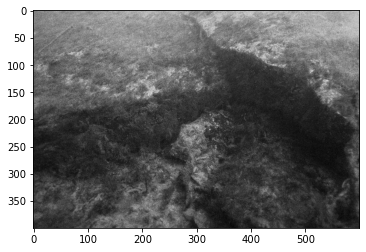

float64


In [5]:
plt.imshow(habitat_img[0], cmap='gray')
plt.show()
print(habitat_img.dtype)

Doing data augmentation and normalization

In [69]:
def fly_over_image(image, window, stride, return_coord=False):
    img_Y = image.shape[-2]
    img_X = image.shape[-3]
    for start_x in range(0, img_X-window[0]+1, stride):
        for start_y in range(0, img_Y-window[1]+1, stride):
            if return_coord:
                yield (start_x, start_x+window[0], start_y, start_y+window[1])
            else:
                sample = image[start_x: start_x+window[0], start_y: start_y + window[1]]
                yield sample
            
def mirror(image):
    return [image, np.flip(image, axis=(-2,-3))]

In [7]:
PREDICTION_SIZE = 100

In [8]:
ext_img_hab = []
for idx, img in enumerate(habitat_img):
    for sample in fly_over_image(img, (PREDICTION_SIZE, PREDICTION_SIZE), PREDICTION_SIZE):
        ext_img_hab += mirror(sample)
ext_img_hab = np.array(ext_img_hab)
#ext_img_hab = (ext_img_hab - np.mean(ext_img_hab)) / np.std(ext_img_hab)
ext_img_hab = (ext_img_hab-np.min(ext_img_hab))/(np.max(ext_img_hab)-np.min(ext_img_hab))

print(ext_img_hab.shape)

(17808, 100, 100, 1)


Splitting the data between train and test

In [9]:
print("number of habitat images: ", ext_img_hab.shape[0])
train, test = train_test_split(ext_img_hab, train_size=0.8, shuffle=True)
print("train: {}, test: {}".format(train.shape[0], test.shape[0]))

number of habitat images:  17808
train: 14246, test: 3562


# Preparing the Auto encoder

In [23]:
LATENT_DIM=500
BATCH_SIZE=50
EPOCHS=20

In [24]:
K.backend.clear_session()
autoencoder = K.Sequential([
    K.layers.Flatten(),
    K.layers.Dense(LATENT_DIM, activation='relu'),
    K.layers.Dense(PREDICTION_SIZE *PREDICTION_SIZE , activation='sigmoid'),
    K.layers.Reshape((PREDICTION_SIZE , PREDICTION_SIZE, 1 ))
])

# Training

In [25]:
autoencoder.compile(optimizer='adam', 
                       loss='mse', 
                       metrics=['accuracy', 'mse']
                      )

In [26]:
history = autoencoder.fit(x=train, y=train, 
                            batch_size=BATCH_SIZE, 
                            validation_data=(test, test),
                            epochs= EPOCHS, 
                            callbacks= []
                            #shuffle= True,
                            #steps_per_epoch=200
                            )

Epoch 1/20
285/285 [==============================] - 3s 9ms/step - loss: 0.0315 - accuracy: 1.4039e-08 - mse: 0.0315 - val_loss: 0.0235 - val_accuracy: 0.0000e+00 - val_mse: 0.0235
Epoch 2/20
285/285 [==============================] - 2s 8ms/step - loss: 0.0203 - accuracy: 1.4039e-08 - mse: 0.0203 - val_loss: 0.0149 - val_accuracy: 0.0000e+00 - val_mse: 0.0149
Epoch 3/20
285/285 [==============================] - 2s 8ms/step - loss: 0.0111 - accuracy: 1.4039e-08 - mse: 0.0111 - val_loss: 0.0138 - val_accuracy: 0.0000e+00 - val_mse: 0.0138
Epoch 4/20
285/285 [==============================] - 2s 8ms/step - loss: 0.0075 - accuracy: 1.4039e-08 - mse: 0.0075 - val_loss: 0.0040 - val_accuracy: 0.0000e+00 - val_mse: 0.0040
Epoch 5/20
285/285 [==============================] - 2s 8ms/step - loss: 0.0039 - accuracy: 1.4039e-08 - mse: 0.0039 - val_loss: 0.0042 - val_accuracy: 0.0000e+00 - val_mse: 0.0042
Epoch 6/20
285/285 [==============================] - 2s 8ms/step - loss: 0.0031 - accurac

In [27]:
plt.plot(history.history['mse'], label="train")
plt.plot(history.history['val_mse'], label="val")
plt.legend()
plt.show()

# Visualize Predictions

In [28]:
sample_test= test[:50]
prediction = autoencoder.predict(sample_test)

In [29]:
print(sample_test.shape, prediction.shape)

(50, 100, 100, 1) (50, 100, 100, 1)


In [30]:
%matplotlib qt
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(sample_test[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(prediction[i])
    plt.title("reconstructed")
    plt.gray()
    mse=K.losses.MSE(sample_test[i], prediction[i])
    ax.set_xlabel("mse: {}".format(mse))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

# Divergence study

### Prepare fish data

In [33]:
FISH_SPECIE = "barrenense"

male_fish_path = glob.glob("../Images/Crops/{}/*_M*.tif".format(FISH_SPECIE))
female_fish_path = glob.glob("../Images/Crops/{}/*_F*.tif".format(FISH_SPECIE))

print("specie: {} / females: {} / males: {}".format(FISH_SPECIE, len(female_fish_path), len(male_fish_path)))

specie: barrenense / females: 43 / males: 42


In [36]:
def preprocess_fish_image(image):
    image = rgb_2_darter(image)
    image = image[..., 0]+image[..., 1]
    image = (image-np.min(image))/(np.max(image)-np.min(image))
    return image[..., np.newaxis]

In [109]:
def get_heat_prediction_fish(img):
    heatmap = np.zeros_like(img)
    ponderation = np.ones_like(img)
    batch = []
    for sample in fly_over_image(img, (PREDICTION_SIZE, PREDICTION_SIZE), PREDICTION_SIZE//5, False):
        batch += [sample]
        
    batch = np.array(batch)
    prediction = autoencoder.predict(batch)
    mse=K.losses.MSE(batch, prediction)
    
    i = 0
    for x1, x2, y1, y2 in fly_over_image(img, (PREDICTION_SIZE, PREDICTION_SIZE), PREDICTION_SIZE//5, True):
        heatmap[x1:x2, y1:y2, 0] += mse[i]
        ponderation[x1:x2, y1:y2, 0] += 1
        i+=1
    return np.divide(heatmap, ponderation)

In [116]:
fishes = []
ht = []

for i, path in enumerate(male_fish_path):
    img = imageio.imread(path)
    fishes += [preprocess_fish_image(img)]
    
for fish in fishes:
    ht += [get_heat_prediction_fish(fish)]


In [122]:


%matplotlib qt
n = 5
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(fishes[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display heatmap
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(ht[i], cmap='hot')
    plt.title("heatmap")
    plt.colorbar()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


plt.show()